<a href="https://colab.research.google.com/github/tanayaagaikwad/Python-Miniprojects1/blob/main/ML_Final_AIRBNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# PART 1: DATA PREPROCESSING AND EDA
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set display options
pd.set_option('display.max_columns', None)


In [ ]:
# Load dataset
df = pd.read_csv('/content/listings.csv')
print("Shape of data:", df.shape)
print("\nFirst few rows:")
print(df.head())

Shape of data: (36111, 79)

First few rows:
         id                            listing_url       scrape_id  \
0  40824219  https://www.airbnb.com/rooms/40824219  20251001171547   
1  40833186  https://www.airbnb.com/rooms/40833186  20251001171547   
2  40837137  https://www.airbnb.com/rooms/40837137  20251001171547   
3  40838018  https://www.airbnb.com/rooms/40838018  20251001171547   
4  40839416  https://www.airbnb.com/rooms/40839416  20251001171547   

  last_scraped           source                                         name  \
0   2025-10-02      city scrape   Room close to  Manhattan for FEMALE guests   
1   2025-10-02  previous scrape  Soho LES East village private room downtown   
2   2025-10-02  previous scrape     Sunset Park - Quiet and close to subway!   
3   2025-10-02  previous scrape             Cozy One Bedroom in Clinton Hill   
4   2025-10-02      city scrape    🪴XL dojo 🌾 shared green yogi palace apt 🌿   

                                         description  

PART 1: DATA PREPROCESSING AND EDA

1. Preprocessing


In [ ]:
# ---- 1.1 Check for Missing Values ----
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing Values (Top 20):")
print(missing.head(20))


Missing Values (Top 20):
calendar_updated               36111
license                        30735
neighborhood_overview          17407
neighbourhood                  17406
host_about                     16496
host_response_time             15774
host_response_rate             15774
host_acceptance_rate           15595
price                          14783
estimated_revenue_l365d        14783
beds                           14468
bathrooms                      14411
review_scores_location         11204
review_scores_value            11204
review_scores_checkin          11202
review_scores_accuracy         11198
review_scores_communication    11194
review_scores_cleanliness      11189
last_review                    11188
review_scores_rating           11188
dtype: int64


In [ ]:
# ---- 1.2 Drop Columns with Excessive Missing Data (>50%) ----
threshold = 0.5
len_df = len(df)
df = df.dropna(thresh=threshold * len_df, axis=1)
print(f"\nShape after dropping high missing columns: {df.shape}")



Shape after dropping high missing columns: (36111, 77)


In [ ]:
# ---- 1.3 Handle Missing Values ----
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['host_name'] = df['host_name'].fillna('Unknown')
df['host_neighbourhood'] = df['host_neighbourhood'].fillna('Unknown')


In [ ]:
# ---- 1.4 Check for Duplicates ----
print(f"\nDuplicates before: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Duplicates after: {df.duplicated().sum()}")



Duplicates before: 0
Duplicates after: 0


In [ ]:
# ---- 1.5 Convert Data Types ----
# Convert price to numeric
if 'price' in df.columns:
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
# Convert lastreview to datetime
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


In [ ]:
# ---- 1.6 Drop Irrelevant Columns ----
irrelevant = ['listing_url', 'scrape_id', 'last_scraped', 'host_url', 'host_thumbnail_url']
df = df.drop(columns=[col for col in irrelevant if col in df.columns], errors='ignore')

print(f"\nShape after cleaning: {df.shape}")



Shape after cleaning: (36111, 72)


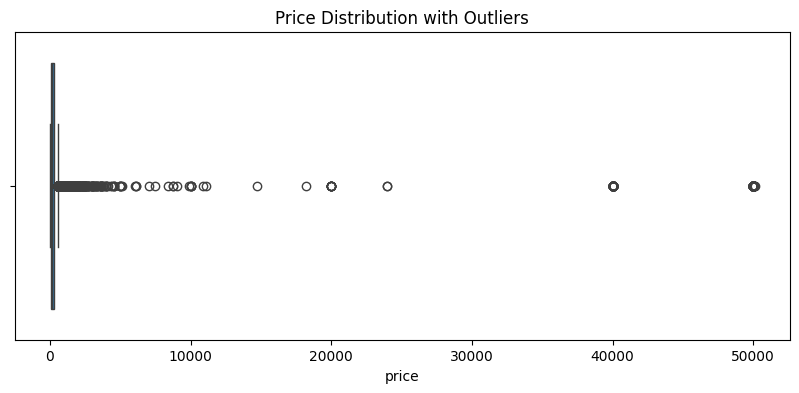

In [ ]:
# ---- 1.7 Handle Outliers (Optional) ----
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price'])
plt.title('Price Distribution with Outliers')
plt.show()

In [ ]:
# Remove extreme price outliers
if 'price' in df.columns:
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['price'] >= Q1 - 1.5*IQR) & (df['price'] <= Q3 + 1.5*IQR)]
    print(f"\nShape after removing outliers: {df.shape}")



Shape after removing outliers: (19808, 72)


In [ ]:
# ---- 1.8 DESCRIPTIVE STATISTICS ----
print("\n=== DESCRIPTIVE STATISTICS ===")
print(df.describe(include='all').T.head(20))



=== DESCRIPTIVE STATISTICS ===
                             count unique  \
id                         19808.0    NaN   
source                       19808      1   
name                         19808  19034   
description                  19442  16034   
neighborhood_overview         9898   7094   
picture_url                  19808  19383   
host_id                    19808.0    NaN   
host_name                    19808   5036   
host_since                   18907   4491   
host_location                14461    363   
host_about                   11172   5348   
host_response_time           15970      4   
host_response_rate           15970     68   
host_acceptance_rate         15841     97   
host_is_superhost            19505      2   
host_picture_url             18907   9514   
host_neighbourhood           19808    427   
host_listings_count        18907.0    NaN   
host_total_listings_count  18907.0    NaN   
host_verifications           18907      6   

                      

2. EDA


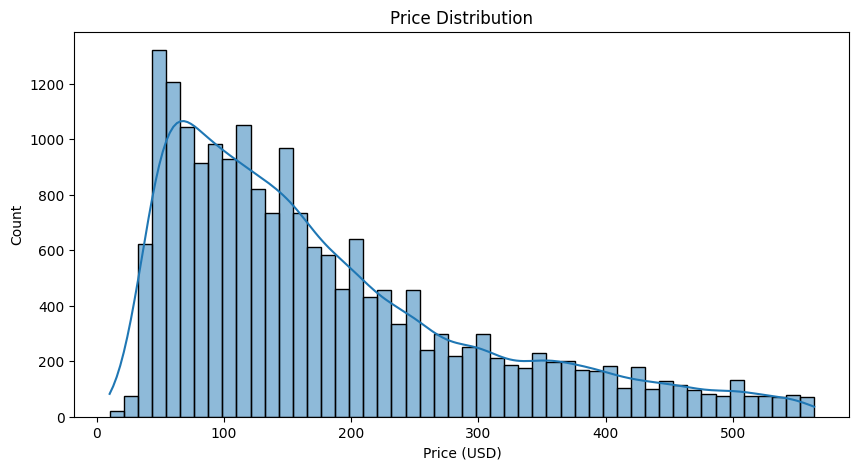

In [ ]:

# ---- 1.9 KEY VISUALIZATIONS ----

# Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (USD)')
plt.ylabel('Count')
plt.show()

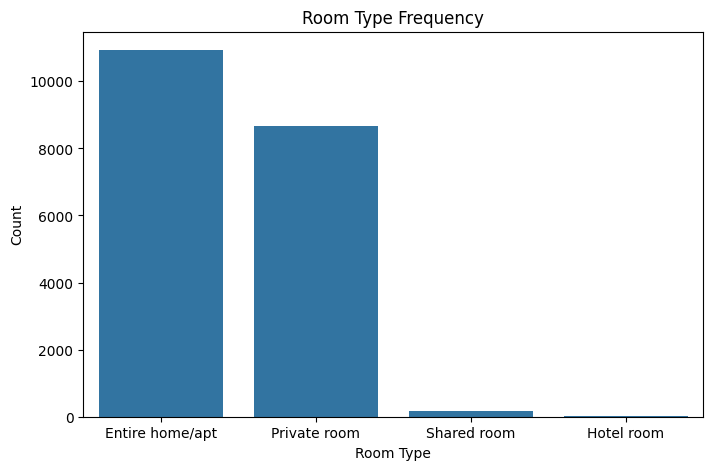

In [ ]:
# Room Type Frequency
plt.figure(figsize=(8, 5))
sns.countplot(x='room_type', data=df, order=df['room_type'].value_counts().index)
plt.title('Room Type Frequency')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Average Price by Room Type
avg_price_room = df.groupby('room_type')['price'].mean().sort_values(ascending=False)
print("\nAverage Price by Room Type:")
print(avg_price_room)


Average Price by Room Type:
room_type
Hotel room         329.366667
Entire home/apt    229.068051
Private room       117.050853
Shared room        100.965318
Name: price, dtype: float64


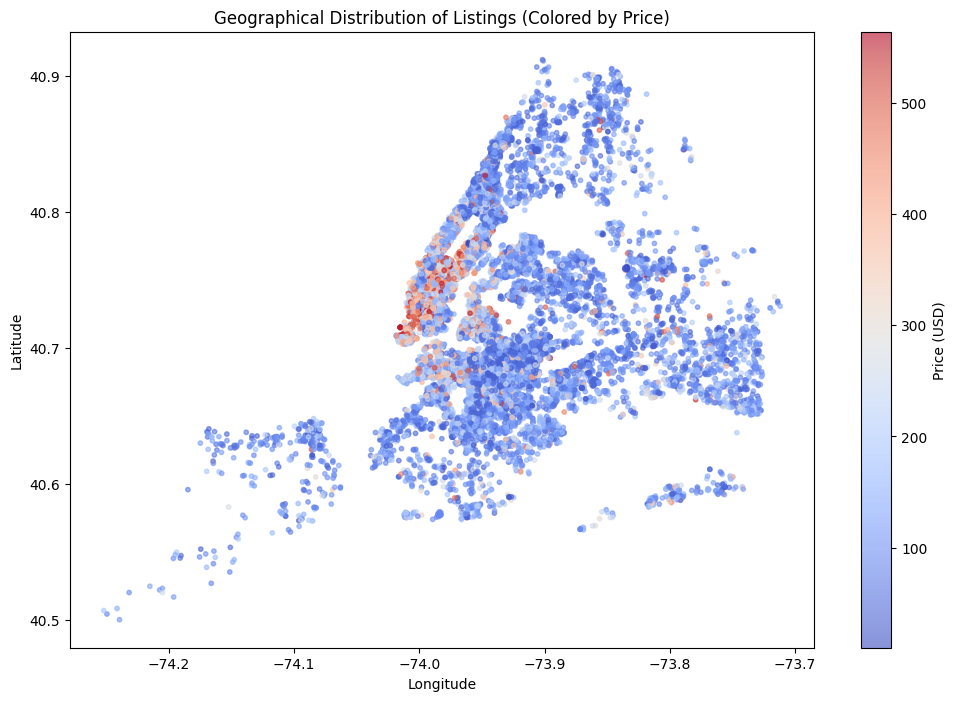

In [ ]:
# Geographical Distribution (if latitude/longitude available)
if 'latitude' in df.columns and 'longitude' in df.columns:
    plt.figure(figsize=(12, 8))
    plt.scatter(df['longitude'], df['latitude'], c=df['price'], cmap='coolwarm', alpha=0.6, s=10)
    plt.title('Geographical Distribution of Listings (Colored by Price)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Price (USD)')
    plt.show()

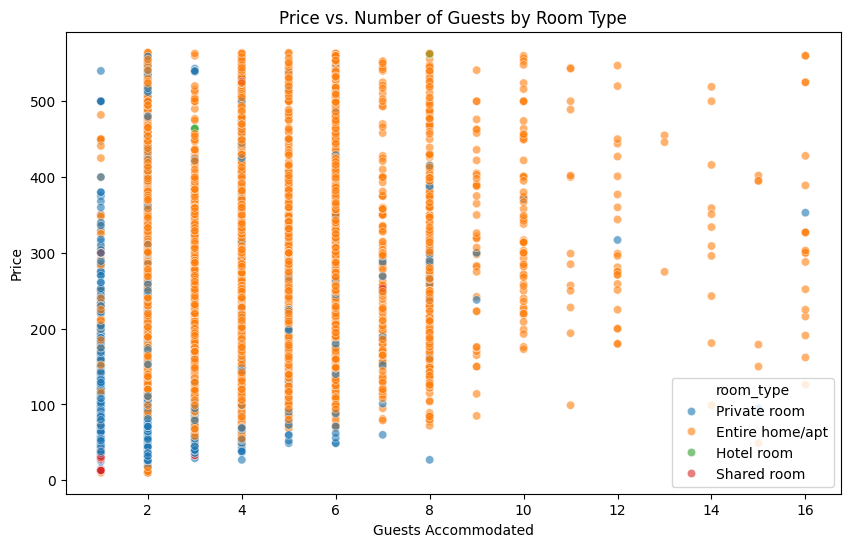

In [ ]:
# Price vs Accommodates by Room Type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='accommodates', y='price', hue='room_type', alpha=0.6)
plt.title('Price vs. Number of Guests by Room Type')
plt.xlabel('Guests Accommodated')
plt.ylabel('Price')
plt.show()

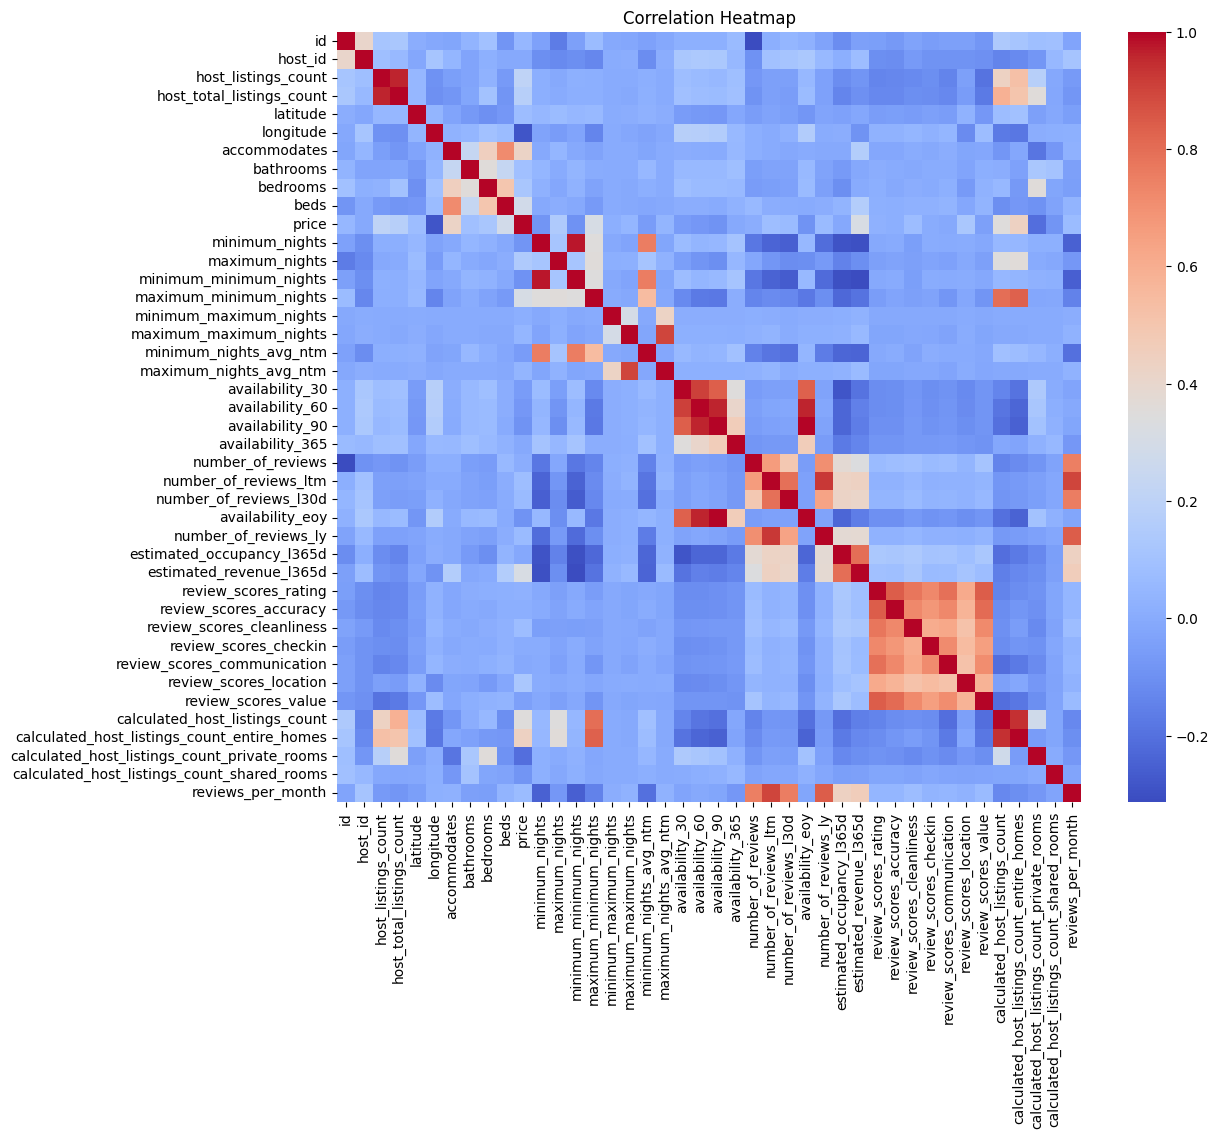

In [ ]:
# ---- 1.10 CORRELATION HEATMAP ----
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

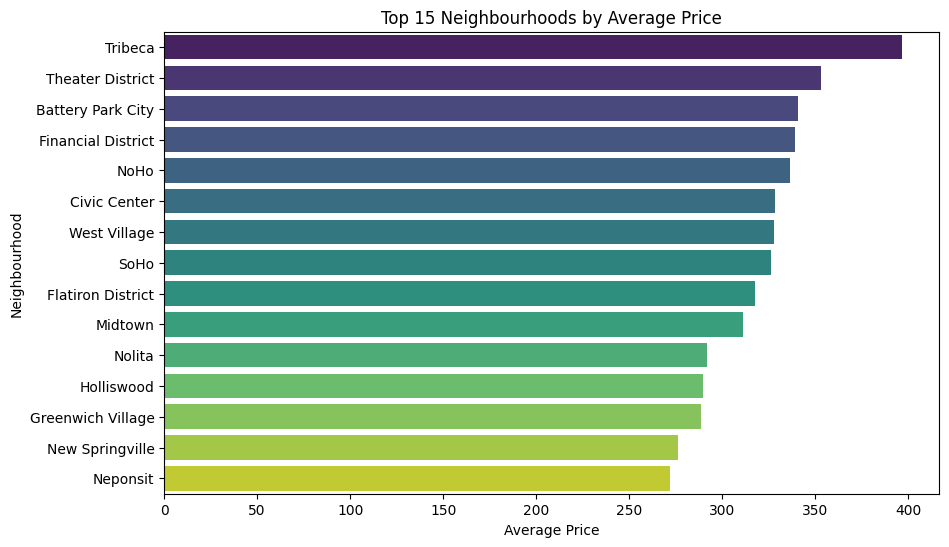

In [ ]:
# Top Neighbourhoods by Average Price
price_by_neigh = df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x=price_by_neigh.values, y=price_by_neigh.index, palette='viridis')
plt.title('Top 15 Neighbourhoods by Average Price')
plt.ylabel('Neighbourhood')
plt.xlabel('Average Price')
plt.show()

In [ ]:
# ---- 1.11 KEY INSIGHTS FROM EDA ----
print("\n=== KEY INSIGHTS FROM EDA ===")
print(f"1. Dataset contains {len(df)} listings across {df['room_type'].nunique()} room types")
print(f"2. Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"3. Average price: ${df['price'].mean():.2f}")
print(f"4. Most common room type: {df['room_type'].value_counts().index}")
print(f"5. Number of unique neighbourhoods: {df['neighbourhood_cleansed'].nunique()}")
print(f"6. Hosts with superhost status: {(df['host_is_superhost'] == 't').sum() if 'host_is_superhost' in df.columns else 'N/A'}")



=== KEY INSIGHTS FROM EDA ===
1. Dataset contains 19808 listings across 4 room types
2. Price range: $10.00 - $564.00
3. Average price: $179.06
4. Most common room type: Index(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'], dtype='object', name='room_type')
5. Number of unique neighbourhoods: 222
6. Hosts with superhost status: 6051


PART 2: PREDICTING HOUSE PRICE USING REGRESSION

In [ ]:
# ============================================
# CORRECTED PART 2: REGRESSION - PRICE PREDICTION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ---- 2.1 Load Dataset ----
try:
    df = pd.read_csv('listings.csv.gz', compression='gzip')
except:
    df = pd.read_csv('listings.csv')  # Alternative if uncompressed

print(f"Dataset shape: {df.shape}")

Dataset shape: (36111, 79)


In [ ]:
# ---- 2.2 Ensure price column is numeric ----
if 'price' in df.columns:
    df['price'] = df['price'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)


In [ ]:
# ---- 2.3 Feature Selection ----
features = [
    'accommodates', 'bedrooms', 'bathrooms', 'beds',
    'property_type', 'room_type', 'neighbourhood_cleansed',
    'number_of_reviews', 'reviews_per_month', 'availability_365',
    'minimum_nights', 'maximum_nights',
    'review_scores_rating', 'review_scores_cleanliness',
    'instant_bookable', 'host_listings_count'
]

target = 'price'

In [ ]:
# ---- 2.4 Check which features exist ----
available_features = [f for f in features if f in df.columns]
print(f"\nAvailable features: {len(available_features)}/{len(features)}")
print(f"Features used: {available_features}")



Available features: 16/16
Features used: ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'property_type', 'room_type', 'neighbourhood_cleansed', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'review_scores_cleanliness', 'instant_bookable', 'host_listings_count']


In [ ]:
# ---- 2.5 Prepare Data ----
df_reg = df[available_features + [target]].copy()
df_reg = df_reg.dropna(subset=[target])
df_reg = df_reg[df_reg[target] > 0]  # Remove zero or negative prices

print(f"Data shape after cleaning: {df_reg.shape}")

X = df_reg[available_features].copy()
y = df_reg[target].copy()


Data shape after cleaning: (21328, 17)


In [ ]:
# ---- 2.6 Identify Categorical and Numerical Features ----
cat_features = [f for f in available_features if df_reg[f].dtype == 'object']
num_features = [f for f in available_features if f not in cat_features]

print(f"\nNumeric features ({len(num_features)}): {num_features}")
print(f"Categorical features ({len(cat_features)}): {cat_features}")



Numeric features (12): ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'review_scores_cleanliness', 'host_listings_count']
Categorical features (4): ['property_type', 'room_type', 'neighbourhood_cleansed', 'instant_bookable']


In [ ]:
# ---- 2.7 Preprocessing Pipeline ----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)
    ],
    remainder='passthrough'
)

In [ ]:
# ---- 2.8 Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")



Training set size: (17062, 16)
Testing set size: (4266, 16)


In [ ]:
# ---- 2.9 Define Models ----
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet Regression': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

In [ ]:
# ---- 2.10 Train and Evaluate Models ----
results_list = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results_list.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })

    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")



--- Training Linear Regression ---
  R² Score: 0.7700
  RMSE: 2254.82
  MAE: 558.52

--- Training Ridge Regression ---
  R² Score: 0.7686
  RMSE: 2261.70
  MAE: 572.54

--- Training Lasso Regression ---
  R² Score: 0.7701
  RMSE: 2254.23
  MAE: 553.62

--- Training ElasticNet Regression ---
  R² Score: 0.4272
  RMSE: 3558.41
  MAE: 1189.39


In [ ]:
# ---- 2.11 Create Results DataFrame ----
results_df = pd.DataFrame(results_list)
print("\n\n=== REGRESSION MODEL COMPARISON ===")
print(results_df.to_string(index=False))

# ---- 2.12 Save Results ----
results_df.to_csv('regression_results.csv', index=False)
print("\nResults saved to 'regression_results.csv'")




Available features: 16/16
Features used: ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'property_type', 'room_type', 'neighbourhood_cleansed', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'review_scores_cleanliness', 'instant_bookable', 'host_listings_count']
Data shape after cleaning: (21328, 17)

Numeric features (12): ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'review_scores_cleanliness', 'host_listings_count']
Categorical features (4): ['property_type', 'room_type', 'neighbourhood_cleansed', 'instant_bookable']

Training set size: (17062, 16)
Testing set size: (4266, 16)

--- Training Linear Regression ---
  R² Score: 0.7700
  RMSE: 2254.82
  MAE: 558.52

--- Training Ridge Regression ---
  R² Score: 0.7686
  RMSE: 2261.70
  MAE: 572.54

--- Training Lasso Regression ---
  R


PART 3: SUPERHOST CLASSIFICATION

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# ---- 3.1 Load and Prepare Data ----
df_class = pd.read_csv('/content/listings.csv')

In [ ]:
# ---- 3.2 Define Target Variable ----
df_class = df_class[df_class['host_is_superhost'].notnull()]
df_class['host_is_superhost'] = df_class['host_is_superhost'].map({'t': 1, 'f': 0})


In [ ]:
# ---- 3.3 Drop Irrelevant Columns ----
drop_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
    'description', 'neighborhood_overview', 'picture_url', 'host_url',
    'host_thumbnail_url', 'host_picture_url', 'calendar_updated',
    'calendar_last_scraped', 'license', 'host_about', 'host_name',
    'host_location', 'neighbourhood', 'neighbourhood_cleansed', 'amenities'
]

df_class = df_class.drop(columns=[c for c in drop_cols if c in df_class.columns], errors='ignore')


In [ ]:
# ---- 3.4 Select Features ----
numeric_cols = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'host_listings_count', 'host_total_listings_count'
]

categorical_cols = [
    'room_type', 'property_type', 'neighbourhood_group_cleansed',
    'host_response_time', 'host_response_rate', 'host_acceptance_rate'
]


In [ ]:
# ---- 3.5 Handle Missing Values (Numeric) ----
for col in numeric_cols:
    if col in df_class.columns:
        df_class[col] = df_class[col].fillna(df_class[col].median())


In [ ]:
# ---- 3.6 Handle Missing Values (Categorical) ----
for col in categorical_cols:
    if col in df_class.columns:
        df_class[col] = df_class[col].fillna('missing')


In [ ]:
# ---- 3.7 Encode Categorical Features ----
from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    if col in df_class.columns:
        le = LabelEncoder()
        df_class[col] = le.fit_transform(df_class[col].astype(str))


In [ ]:
# ---- 3.8 Prepare Features and Target ----
target = 'host_is_superhost'
features = numeric_cols + categorical_cols

X = df_class[features].copy()
y = df_class[target]

In [ ]:
# ---- 3.9 Scale Features ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# ---- 3.10 Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# ---- 3.11 Train Decision Tree Classifier ----
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
# ---- 3.12 Make Predictions ----
y_pred = clf.predict(X_test)

In [ ]:
# ---- 3.13 Evaluate Model ----
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== SUPERHOST CLASSIFICATION RESULTS ===")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-Score:  {f1:.3f}")


=== SUPERHOST CLASSIFICATION RESULTS ===
Accuracy:  0.877
Precision: 0.708
Recall:    0.664
F1-Score:  0.685



Confusion Matrix:
[[5314  393]
 [ 484  955]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5707
           1       0.71      0.66      0.69      1439

    accuracy                           0.88      7146
   macro avg       0.81      0.80      0.80      7146
weighted avg       0.87      0.88      0.88      7146



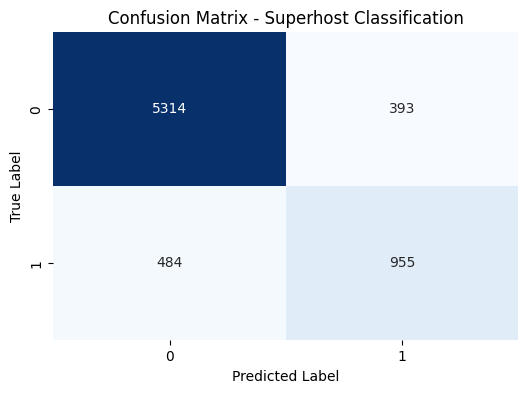

In [ ]:
# ---- 3.14 Confusion Matrix and Classification Report ----
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Superhost Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


PART 4: MODEL COMPARISON - SVM vs NAIVE BAYES vs DECISION TREE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
start_time = time.time()

# ---- 4.1 Load Dataset ----
try:
    df_models = pd.read_csv('listings.csv.gz', compression='gzip')
except:
    df_models = pd.read_csv('listings.csv')


print(f"\nDataset shape: {df_models.shape}")



Dataset shape: (36111, 79)


In [ ]:
# ---- 4.2 Check if target exists ----
if 'host_is_superhost' not in df_models.columns:
    print("ERROR: 'host_is_superhost' column not found!")
    print(f"Available columns: {df_models.columns.tolist()}")
else:
    # ---- 4.3 Prepare Target Variable ----
    df_models = df_models[df_models['host_is_superhost'].notnull()].copy()

    if df_models['host_is_superhost'].dtype == 'object':
        df_models['host_is_superhost'] = df_models['host_is_superhost'].map({
            't': 1, 'f': 0, 'True': 1, 'False': 0, True: 1, False: 0
        })
    print(f"Target distribution:")
    print(df_models['host_is_superhost'].value_counts())


Target distribution:
host_is_superhost
0    28533
1     7194
Name: count, dtype: int64


In [ ]:
  # ---- 4.4 Drop Irrelevant Columns ----
  drop_cols = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
        'description', 'neighborhood_overview', 'picture_url', 'host_url',
        'host_thumbnail_url', 'host_picture_url', 'calendar_updated',
        'calendar_last_scraped', 'license', 'host_about', 'host_name',
        'host_location', 'neighbourhood', 'amenities'
    ]

  df_models = df_models.drop(columns=[c for c in drop_cols if c in df_models.columns],
                                errors='ignore')



PART 4: FAST MODEL COMPARISON (Optimized)

Dataset shape: (36111, 79)
Target distribution:
host_is_superhost
0    28533
1     7194
Name: count, dtype: int64

Numeric features: 17 | Categorical features: 6
Handling missing values...
Encoding categorical features...

Original data: (35727, 23) samples
Sample for tuning: (14290, 23) samples (40%)
ℹ️  Using 40% sample for hyperparameter tuning to speed up training

Scaling features...
Train set: (28581, 23) | Test set: (7146, 23)

BASELINE MODEL: Decision Tree (Default)
Baseline Accuracy: 0.8811 | F1-Score: 0.7045 ✓

MODEL 1: SVM with RandomizedSearchCV (FAST)
RandomizedSearchCV (n_iter=6, cv=2)...
✓ Best SVM Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
  Best CV F1-Score: 0.6033

MODEL 2: Decision Tree with RandomizedSearchCV (FAST)
RandomizedSearchCV (n_iter=8, cv=2)...
✓ Best Decision Tree Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 20}
  Best CV F1-Score: 0.6419

MODEL 3: Gaussian Naive Bayes 

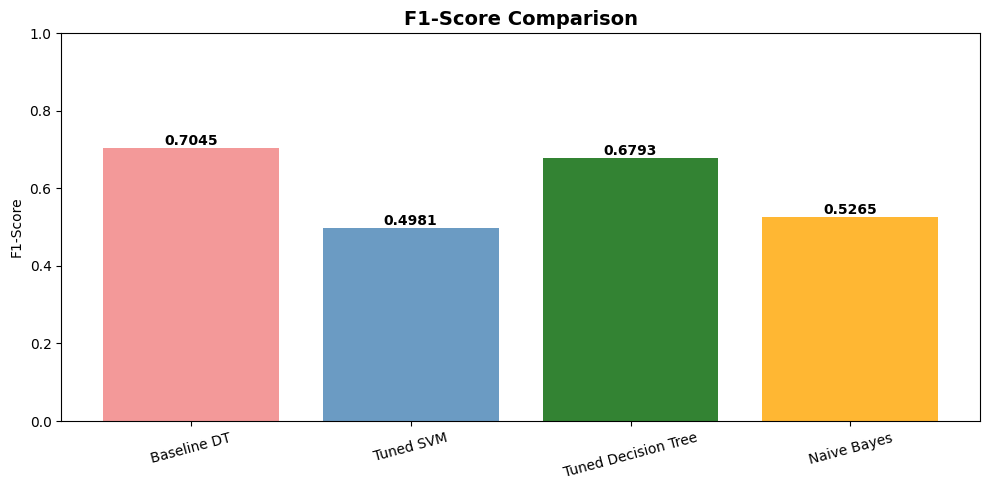

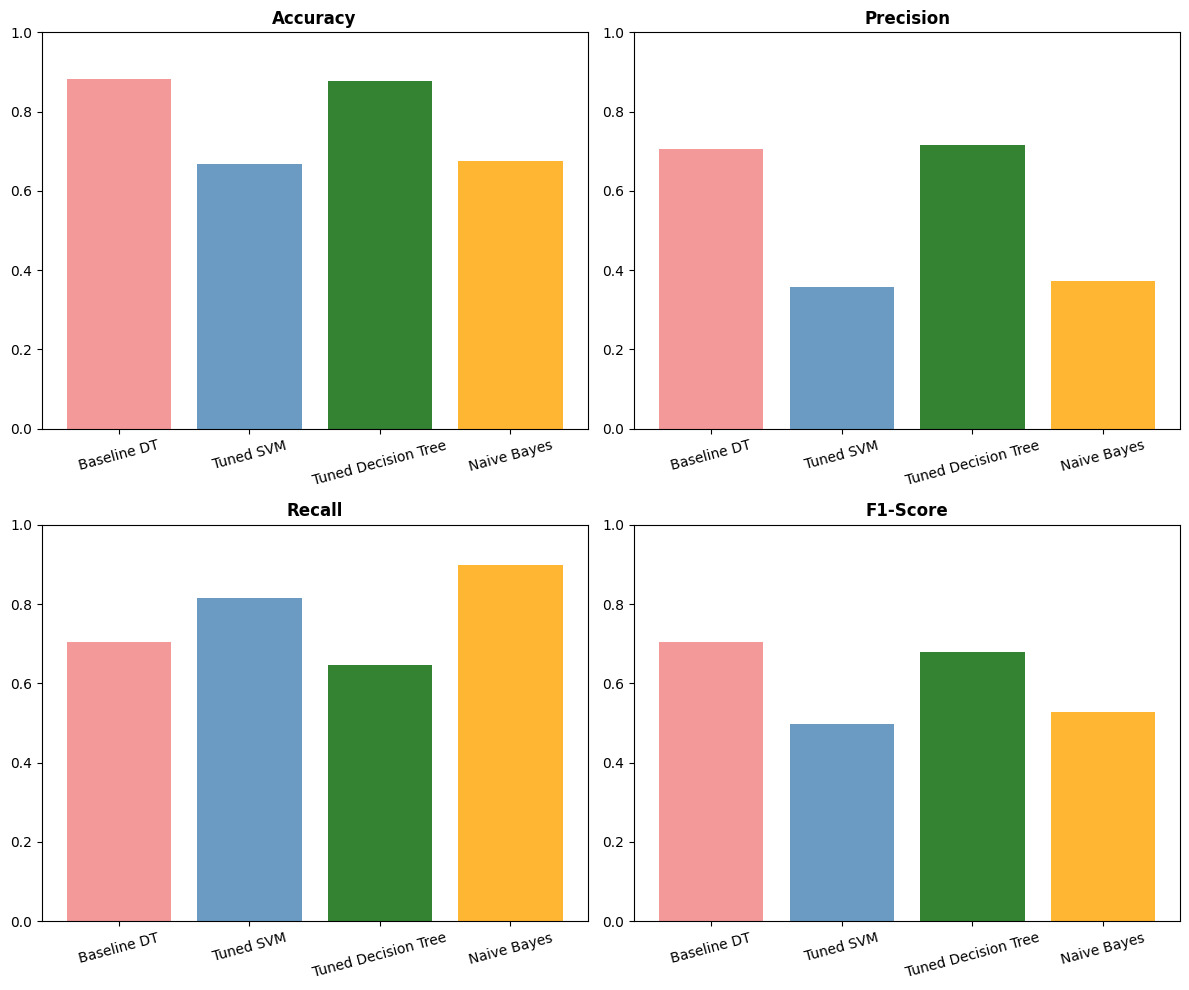

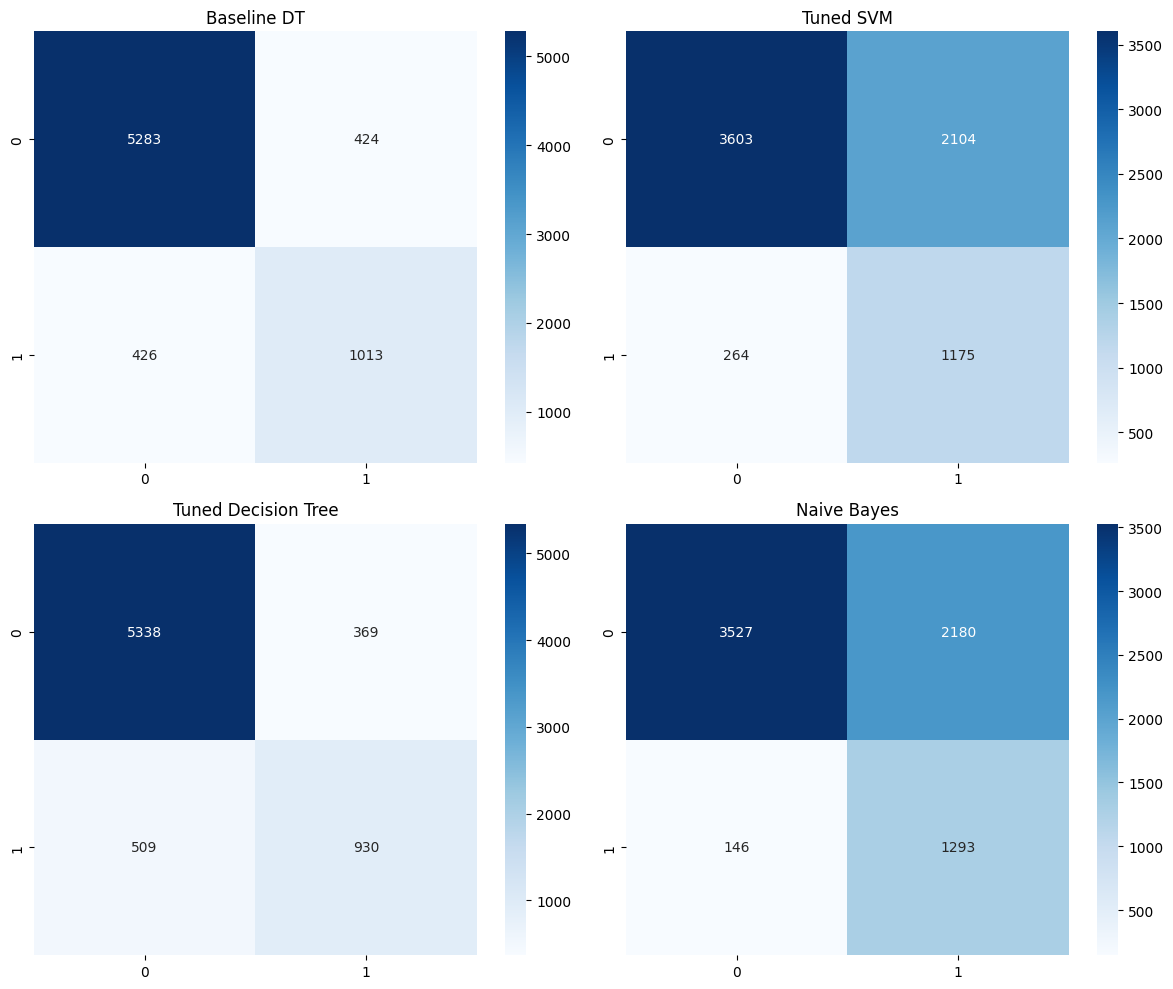

In [ ]:



start_time = time.time()

# ---- 4.1 Load Dataset ----
try:
    df_models = pd.read_csv('listings.csv.gz', compression='gzip')
except:
    df_models = pd.read_csv('listings.csv')

print(f"\nDataset shape: {df_models.shape}")

# ---- 4.2 Check if target exists ----
if 'host_is_superhost' not in df_models.columns:
    print("ERROR: 'host_is_superhost' column not found!")
    print(f"Available columns: {df_models.columns.tolist()}")
else:
    # ---- 4.3 Prepare Target Variable ----
    df_models = df_models[df_models['host_is_superhost'].notnull()].copy()

    if df_models['host_is_superhost'].dtype == 'object':
        df_models['host_is_superhost'] = df_models['host_is_superhost'].map({
            't': 1, 'f': 0, 'True': 1, 'False': 0, True: 1, False: 0
        })

    print(f"Target distribution:")
    print(df_models['host_is_superhost'].value_counts())

    # ---- 4.4 Drop Irrelevant Columns ----
    drop_cols = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
        'description', 'neighborhood_overview', 'picture_url', 'host_url',
        'host_thumbnail_url', 'host_picture_url', 'calendar_updated',
        'calendar_last_scraped', 'license', 'host_about', 'host_name',
        'host_location', 'neighbourhood', 'amenities'
    ]

    df_models = df_models.drop(columns=[c for c in drop_cols if c in df_models.columns],
                                errors='ignore')

    # ---- 4.5 Define Features ----
    possible_numeric = [
        'accommodates', 'bedrooms', 'beds', 'bathrooms',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'host_listings_count', 'host_total_listings_count',
        'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights'
    ]

    possible_categorical = [
        'room_type', 'property_type', 'neighbourhood_group_cleansed',
        'host_response_time', 'host_response_rate', 'host_acceptance_rate'
    ]

    numeric_cols = [col for col in possible_numeric if col in df_models.columns]
    categorical_cols = [col for col in possible_categorical if col in df_models.columns]

    print(f"\nNumeric features: {len(numeric_cols)} | Categorical features: {len(categorical_cols)}")

    # ---- 4.6 Handle Missing Values ----
    print("Handling missing values...")

    for col in numeric_cols:
        if col in df_models.columns:
            df_models[col] = df_models[col].fillna(df_models[col].median())

    for col in categorical_cols:
        if col in df_models.columns:
            df_models[col] = df_models[col].fillna('missing')

    # ---- 4.7 Handle Percentage Columns ----
    for col in ['host_response_rate', 'host_acceptance_rate']:
        if col in df_models.columns and df_models[col].dtype == 'object':
            df_models[col] = df_models[col].astype(str).str.replace('%', '').str.replace(',', '')
            df_models[col] = pd.to_numeric(df_models[col], errors='coerce')
            df_models[col] = df_models[col].fillna(df_models[col].median())

    # ---- 4.8 Encode Categorical Features ----
    print("Encoding categorical features...")

    for col in categorical_cols:
        if col in df_models.columns:
            le = LabelEncoder()
            df_models[col] = le.fit_transform(df_models[col].astype(str))

    # ---- 4.9 Prepare Features and Target ----
    all_features = numeric_cols + categorical_cols
    df_models = df_models[all_features + ['host_is_superhost']].dropna()

    X = df_models[all_features].copy()
    y = df_models['host_is_superhost'].copy()

    # ============================================================
    # SPEED OPTIMIZATION: SAMPLE DATA FOR FASTER TUNING
    # ============================================================
    # Use stratified sample to speed up hyperparameter tuning
    X_sample, _, y_sample, _ = train_test_split(
        X, y, train_size=0.4, random_state=42, stratify=y
    )

    print(f"\nOriginal data: {X.shape} samples")
    print(f"Sample for tuning: {X_sample.shape} samples (40%)")
    print("ℹ️  Using 40% sample for hyperparameter tuning to speed up training")

    # ---- 4.10 Scale Features ----
    print("\nScaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_sample_scaled = scaler.transform(X_sample)

    # ---- 4.11 Train-Test Split (FULL DATA) ----
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Train set: {X_train.shape} | Test set: {X_test.shape}")

    # ---- 4.12 Train-Test Split for Tuning (SAMPLE) ----
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
        X_sample_scaled, y_sample, test_size=0.2, random_state=42, stratify=y_sample
    )

    # ============================================================
    # BASELINE MODEL: Decision Tree (Fast)
    # ============================================================
    print("\n" + "="*70)
    print("BASELINE MODEL: Decision Tree (Default)")
    print("="*70)

    baseline_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
    baseline_dt.fit(X_train, y_train)
    baseline_pred = baseline_dt.predict(X_test)

    baseline_acc = accuracy_score(y_test, baseline_pred)
    baseline_f1 = f1_score(y_test, baseline_pred)

    print(f"Baseline Accuracy: {baseline_acc:.4f} | F1-Score: {baseline_f1:.4f} ✓")

    # ============================================================
    # SVM WITH RANDOMIZED SEARCH (FAST)
    # ============================================================
    print("\n" + "="*70)
    print("MODEL 1: SVM with RandomizedSearchCV (FAST)")
    print("="*70)

    svm_params = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }

    print("RandomizedSearchCV (n_iter=6, cv=2)...")
    svm_search = RandomizedSearchCV(
        SVC(probability=True, random_state=42, max_iter=1000),
        param_distributions=svm_params,
        n_iter=6,  # Test only 6 random combinations
        cv=2,      # Only 2-fold CV (instead of 3)
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    svm_search.fit(X_train_sample, y_train_sample)  # Train on sample
    svm_best = svm_search.best_estimator_

    print(f"✓ Best SVM Parameters: {svm_search.best_params_}")
    print(f"  Best CV F1-Score: {svm_search.best_score_:.4f}")

    # ============================================================
    # DECISION TREE WITH RANDOMIZED SEARCH (FAST)
    # ============================================================
    print("\n" + "="*70)
    print("MODEL 2: Decision Tree with RandomizedSearchCV (FAST)")
    print("="*70)

    dt_params = {
        'max_depth': [5, 10, 15, 20],
        'min_samples_leaf': [1, 5, 10],
        'min_samples_split': [2, 5, 10]
    }

    print("RandomizedSearchCV (n_iter=8, cv=2)...")
    dt_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_distributions=dt_params,
        n_iter=8,  # Test only 8 random combinations
        cv=2,      # Only 2-fold CV
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    dt_search.fit(X_train_sample, y_train_sample)  # Train on sample
    dt_best = dt_search.best_estimator_

    print(f"✓ Best Decision Tree Parameters: {dt_search.best_params_}")
    print(f"  Best CV F1-Score: {dt_search.best_score_:.4f}")

    # ============================================================
    # NAIVE BAYES (FASTEST - No Tuning)
    # ============================================================
    print("\n" + "="*70)
    print("MODEL 3: Gaussian Naive Bayes (INSTANT)")
    print("="*70)

    nb = GaussianNB()
    nb.fit(X_train, y_train)
    print("✓ Naive Bayes trained (no hyperparameters)")

    # ============================================================
    # EVALUATE ALL MODELS ON FULL TEST SET
    # ============================================================
    print("\n" + "="*70)
    print("FINAL EVALUATION (on Full Test Set)")
    print("="*70)

    models_dict = {
        'Baseline DT': baseline_dt,
        'Tuned SVM': svm_best,
        'Tuned Decision Tree': dt_best,
        'Naive Bayes': nb
    }

    results_list = []
    cm_dict = {}

    for name, model in models_dict.items():
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        results_list.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })

        cm_dict[name] = cm

        print(f"\n{name}:")
        print(f"  Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

    # ============================================================
    # RESULTS TABLE
    # ============================================================
    results_df = pd.DataFrame(results_list)

    print("\n" + "="*70)
    print("MODEL COMPARISON TABLE")
    print("="*70)
    print(results_df.to_string(index=False))
    results_df.to_csv('model_comparison_results.csv', index=False)

    # ============================================================
    # FAST VISUALIZATIONS
    # ============================================================

    # Plot 1: F1-Score Comparison
    plt.figure(figsize=(10, 5))
    colors = ['lightcoral', 'steelblue', 'darkgreen', 'orange']
    bars = plt.bar(results_df['Model'], results_df['F1-Score'], color=colors, alpha=0.8)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.title('F1-Score Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('f1_comparison.png', dpi=300)
    plt.show()

    # Plot 2: All Metrics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        ax.bar(results_df['Model'], results_df[metric], color=colors, alpha=0.8)
        ax.set_title(f'{metric}', fontweight='bold')
        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.savefig('all_metrics.png', dpi=300)
    plt.show()

    # Plot 3: Confusion Matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (name, cm) in enumerate(cm_dict.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{name}')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300)
    plt.show()



 PART 5: ADVANCED - PREDICT SUPERHOST PROBABILITY


Training Logistic Regression and XGBoost...

=== PROBABILITY MODEL EVALUATION ===

Logistic Regression:
  ROC-AUC: 0.856
  Brier Score: 0.1159

XGBoost:
  ROC-AUC: 0.963
  Brier Score: 0.0627


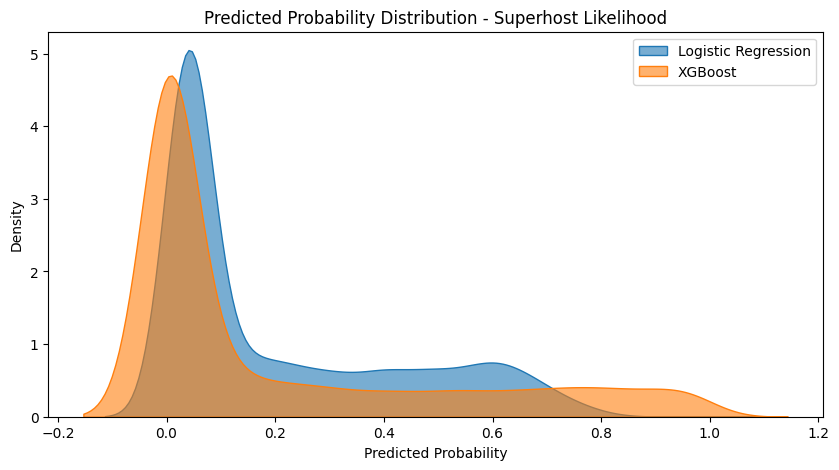

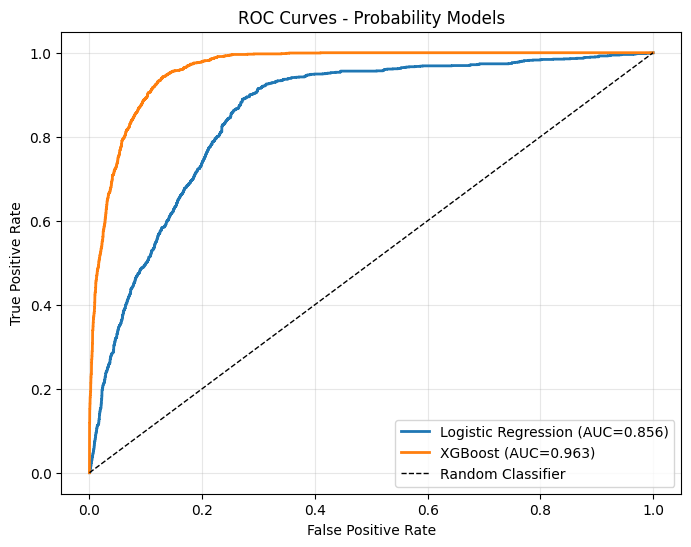



=== PREDICTING SUPERHOST PROBABILITY FOR NEW HOSTS ===

Host 1 (Moderately Active):
  Predicted Probability of Becoming Superhost: 13.34%

Host 2 (Highly Active):
  Predicted Probability of Becoming Superhost: 97.85%

=== KEY INSIGHTS ===

Factors that increase Superhost probability:
  1. High review scores (especially cleanliness and communication)
  2. Quick host response time (within an hour)
  3. High response and acceptance rates (90%+)
  4. Entire home/apartment listings
  5. Prime neighbourhood locations
  6. Consistent positive guest feedback

COMPLETE ML PIPELINE SUCCESSFULLY EXECUTED!


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# ---- 5.1 Load and Prepare Data ----
df_adv = pd.read_csv('/content/listings.csv')

df_adv = df_adv[df_adv['host_is_superhost'].notnull()]
df_adv['host_is_superhost'] = df_adv['host_is_superhost'].map({'t': 1, 'f': 0})

# ---- 5.2 Select Features ----
features = [
    'host_listings_count', 'host_total_listings_count', 'host_response_time',
    'host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'property_type', 'room_type', 'neighbourhood_group_cleansed'
]

df_adv = df_adv[features + ['host_is_superhost']].copy()

# ---- 5.3 Handle Missing Values (Numeric) ----
for col in ['host_response_rate', 'host_acceptance_rate']:
    if col in df_adv.columns:
        df_adv[col] = df_adv[col].replace('[%,]', '', regex=True).astype(float)

for col in df_adv.select_dtypes(include=[np.number]).columns:
    df_adv[col] = df_adv[col].fillna(df_adv[col].median())

# ---- 5.4 Handle Missing Values (Categorical) ----
cat_cols = ['host_response_time', 'property_type', 'room_type', 'neighbourhood_group_cleansed']

# Store label encoders to inverse transform later if needed
label_encoders = {}
for c in cat_cols:
    if c in df_adv.columns:
        df_adv[c] = df_adv[c].fillna('missing')
        le = LabelEncoder()
        df_adv[c] = le.fit_transform(df_adv[c].astype(str))
        label_encoders[c] = le


# ---- 5.5 Prepare Features and Target ----
X = df_adv.drop(columns=['host_is_superhost'])
y = df_adv['host_is_superhost']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ---- 5.6 Train Models ----
print("\nTraining Logistic Regression and XGBoost...")

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

logreg.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# ---- 5.7 Predict Probabilities ----
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# ---- 5.8 Evaluate Probability Models ----
print("\n=== PROBABILITY MODEL EVALUATION ===\n")

print("Logistic Regression:")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_logreg):.3f}")
print(f"  Brier Score: {brier_score_loss(y_test, y_prob_logreg):.4f}")

print("\nXGBoost:")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.3f}")
print(f"  Brier Score: {brier_score_loss(y_test, y_prob_xgb):.4f}")

# ---- 5.9 Plot Predicted Probability Distribution ----
plt.figure(figsize=(10, 5))
sns.kdeplot(y_prob_logreg, label='Logistic Regression', fill=True, alpha=0.6)
sns.kdeplot(y_prob_xgb, label='XGBoost', fill=True, alpha=0.6)
plt.title('Predicted Probability Distribution - Superhost Likelihood')
plt.xlabel('Predicted Probability')
plt.legend()
plt.show()

# ---- 5.10 ROC Curves ----
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, y_prob_logreg):.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_prob_xgb):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Probability Models')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---- 5.11 Predict Probability for New Hosts ----
print("\n\n=== PREDICTING SUPERHOST PROBABILITY FOR NEW HOSTS ===\n")

# Example 1: Moderately Active Host
# Note: Categorical features need to be encoded using the same LabelEncoders fitted on the training data
newhost = pd.DataFrame({
    'host_listings_count': [5],
    'host_total_listings_count': [10],
    'host_response_time': [label_encoders['host_response_time'].transform(['within a few hours'])[0]],  # Encoded value
    'host_response_rate': [90.0],
    'host_acceptance_rate': [85.0],
    'accommodates': [2],
    'bathrooms': [1.0],
    'bedrooms': [1],
    'beds': [1.0],
    'review_scores_rating': [4.5],
    'review_scores_accuracy': [4.6],
    'review_scores_cleanliness': [4.5],
    'review_scores_checkin': [4.7],
    'review_scores_communication': [4.8],
    'review_scores_location': [4.5],
    'review_scores_value': [4.4],
    'property_type': [label_encoders['property_type'].transform(['Private room in rental unit'])[0]], # Example type
    'room_type': [label_encoders['room_type'].transform(['Private room'])[0]],  # Example room type
    'neighbourhood_group_cleansed': [label_encoders['neighbourhood_group_cleansed'].transform(['Brooklyn'])[0]] # Example neighbourhood group
})

newhost_scaled = scaler.transform(newhost)
probability1 = xgb.predict_proba(newhost_scaled)[:, 1]

print(f"Host 1 (Moderately Active):")
print(f"  Predicted Probability of Becoming Superhost: {probability1[0]*100:.2f}%\n")

# Example 2: Highly Active Host
# Note: Categorical features need to be encoded using the same LabelEncoders fitted on the training data
newhost2 = pd.DataFrame({
    'host_listings_count': [50],
    'host_total_listings_count': [100],
    'host_response_time': [label_encoders['host_response_time'].transform(['within an hour'])[0]],  # Within an hour
    'host_response_rate': [100.0],
    'host_acceptance_rate': [95.0],
    'accommodates': [4],
    'bathrooms': [2.0],
    'bedrooms': [2],
    'beds': [2.0],
    'review_scores_rating': [4.9],
    'review_scores_accuracy': [5.0],
    'review_scores_cleanliness': [4.9],
    'review_scores_checkin': [5.0],
    'review_scores_communication': [5.0],
    'review_scores_location': [4.8],
    'review_scores_value': [4.9],
    'property_type': [label_encoders['property_type'].transform(['Entire rental unit'])[0]],  # Entire home/apt
    'room_type': [label_encoders['room_type'].transform(['Entire home/apt'])[0]],  # Entire home/apt
    'neighbourhood_group_cleansed': [label_encoders['neighbourhood_group_cleansed'].transform(['Manhattan'])[0]]   # Manhattan
})

newhost2_scaled = scaler.transform(newhost2)
probability2 = xgb.predict_proba(newhost2_scaled)[:, 1]

print(f"Host 2 (Highly Active):")
print(f"  Predicted Probability of Becoming Superhost: {probability2[0]*100:.2f}%\n")


